In [37]:
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# pip install np_utils and then restart your terminal if you get error
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Activation
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K


In [38]:
FS_AXIS_LABEL=14
FS_TITLE=17
FS_TICKS=12
FIG_WIDTH=20
ROW_HEIGHT=3
TEXT_SPACING=4
RESIZE_DIM_48=48
RESIZE_DIM=28

In [39]:
data_dir=os.path.join('..','/home/hasib/Hasib/Others/NumtaDB_with_aug')
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

# training labels
path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

#display a path
print(path_label_train_d)

/home/hasib/Hasib/Others/NumtaDB_with_aug/training-d.csv


# Read Image

In [42]:
path_a=paths_train_a[0]
path_b=paths_train_b[0]
path_c=paths_train_c[0]
path_d=paths_train_d[0]
path_e=paths_train_e[0]

img=cv2.imread(path_a) # cv2 stores image in BGR format
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # transforming to RGB format
print(path_a) #show path location

/home/hasib/Hasib/Others/NumtaDB_with_aug/training-a/a04667.png


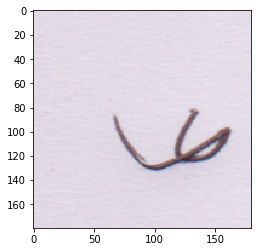

In [43]:
plt.imshow(img)
plt.show()

In [44]:
dfa = pd.read_csv(path_label_train_a) # store the execl in a pandas dataframe
dfb = pd.read_csv(path_label_train_b)
dfc = pd.read_csv(path_label_train_c)
dfd = pd.read_csv(path_label_train_d)
dfe = pd.read_csv(path_label_train_e)

dfa=dfa.set_index('filename') 
dfb=dfb.set_index('filename') 
dfc=dfc.set_index('filename') 
dfd=dfd.set_index('filename') 
dfe=dfe.set_index('filename') 
dfa.head() # observe first five rows
dfb.head()
dfc.head()
dfd.head()
dfe.head()


,original filename,districtid,institutionid,gender,age,datestamp,scanid,digit,database name original,database name
filename,,,,,,,,,,
e00000.png,02_0002_1_20_1016_1248_60.png,2,2,1,20,1016,1248,9,BanglaLekha-Isolated,training-e
e00001.png,02_0002_0_19_1016_1183_60.png,2,2,0,19,1016,1183,9,BanglaLekha-Isolated,training-e
e00002.png,01_0001_0_16_0916_0464_51.png,1,1,0,16,916,464,0,BanglaLekha-Isolated,training-e
e00003.png,02_0002_0_24_1016_1464_55.png,2,2,0,24,1016,1464,4,BanglaLekha-Isolated,training-e
e00004.png,02_0002_0_18_1016_1718_56.png,2,2,0,18,1016,1718,5,BanglaLekha-Isolated,training-e


In [45]:
def get_key(path):
    key=path.split(sep=os.sep)[-1]
    return key

def get_data1(path, resize_dim=RESIZE_DIM_48):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_rz=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
    img_rz_rs=img_rz/255
    return img_rz_rs

def get_data(paths_img,path_label=None,resize_dim=None):
    X=[] 
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_COLOR) 
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) 
        X.append(img) 
      
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) 
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) 
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] 
        y=to_categorical(y_label,10) 
        return X, y

def imshow_group(X,y=None,y_pred=None,n_per_row=10):
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,ROW_HEIGHT*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
        plt.imshow(img)
        if y is not None:
                plt.title('true label: {}'.format(np.argmax(y[i])))
        if y_pred is not None:
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
        plt.axis('off')
    plt.show()
    
def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

In [10]:
X_train_a_48,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM_48)
X_train_b_48,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM_48)
X_train_c_48,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM_48)
X_train_d_48,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM_48)
X_train_e_48,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM_48)

processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [34]:
X_train_all=np.concatenate((X_train_a_48,X_train_b_48,X_train_c_48, X_train_d_48, X_train_e_48),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c, y_train_d, y_train_e),axis=0)
X_train_all.shape, y_train_all.shape

((72045, 48, 48, 3), (72045, 10))

In [35]:
indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)
ind=int(len(indices)*0.80) # model will be trained with 80% of the training data

# training data
X_train=X_train_all[indices[:ind]] 
y_train=y_train_all[indices[:ind]] 

# validation data
X_val=X_train_all[indices[-(len(indices)-ind):]] 
y_val=y_train_all[indices[-(len(indices)-ind):]] 


In [36]:
print(X_train_all.shape)
print(y_train_all.shape)
print("   ")
print(X_train.shape)
print(y_train.shape)
print("   ")
print(X_val.shape)
print(y_val.shape)

(72045, 48, 48, 3)
(72045, 10)
   
(57636, 48, 48, 3)
(57636, 10)
   
(14409, 48, 48, 3)
(14409, 10)


In [32]:
from keras.applications.vgg16 import VGG16

def create_model_vgg16():
    base_model = VGG16(weights='imagenet',include_top=False,pooling='avg',input_shape=(48, 48, 3))
    X = base_model.output
    predictions = Dense(10, activation='softmax')(X)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [33]:
model = create_model_vgg16()
path_model='model_TL_VGG16.h5'
batch_size=16
epochs = 1
history =  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[
                ModelCheckpoint(filepath=path_model),
            ])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [35]:
RESIZE_DIM = 48 #new dimension for input to model

X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)

processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 495/495
processed 2168/2168
processed 2106/2106


In [36]:
X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))

In [37]:
X_test_all.shape

(17626, 48, 48, 3)

In [38]:
predictions_prob=model.predict(X_test_all) 

In [39]:
n_sample=200
np.random.seed(42)
ind=np.random.randint(0,len(X_test_all), size=n_sample)

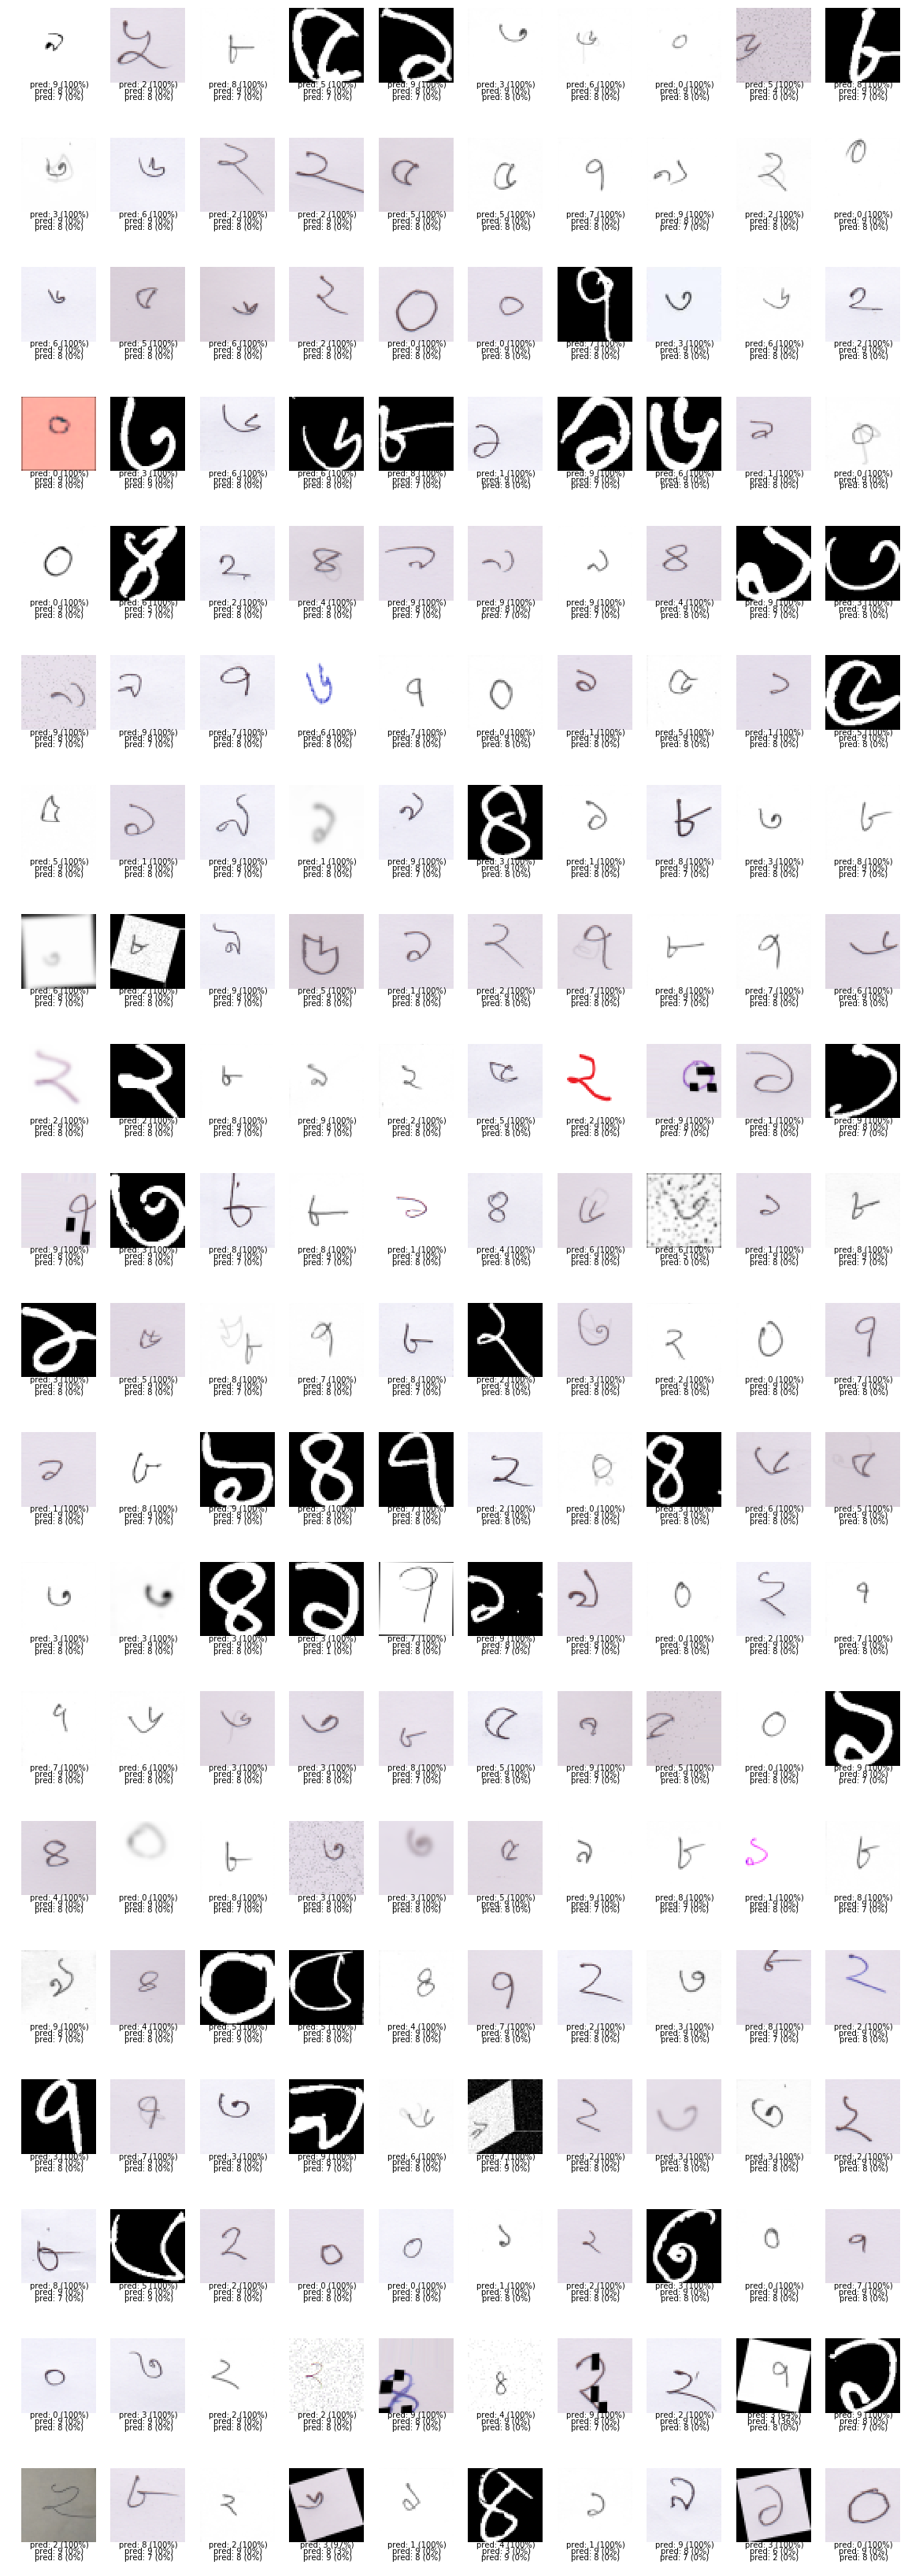

In [40]:
imshow_group(X=X_test_all[ind],y=None,y_pred=predictions_prob[ind])

In [41]:
labels=[np.argmax(pred) for pred in predictions_prob]

In [42]:
keys=[get_key(path) for path in paths_test_all ]

In [43]:
def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

In [44]:
create_submission(predictions=labels,keys=keys,path='hasib_keras_TFrun_5epochs_june_14.csv')